In [5]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from training import BreastDataset, load_split_data, get_network, val_transform, train_transform  # reuse existing helpers
import os
import numpy as np

(224, 224)
(224, 224)
[0. 1.]


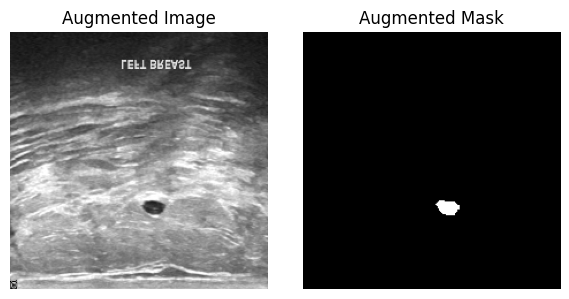

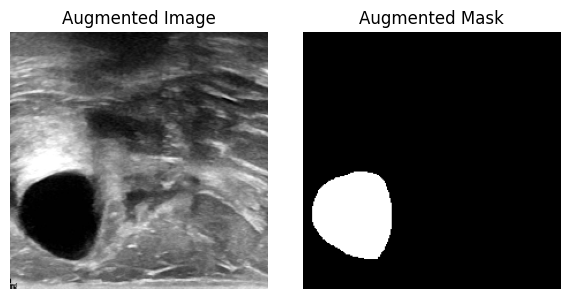

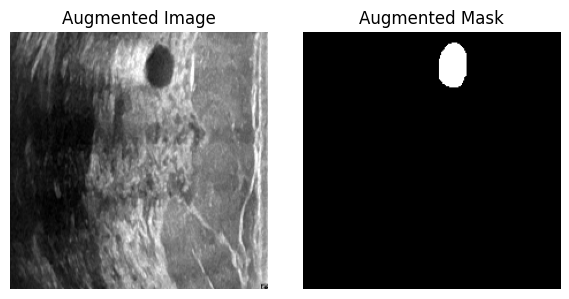

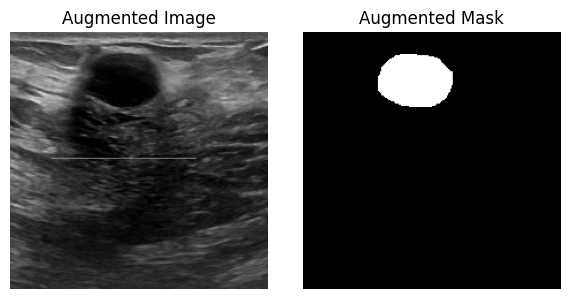

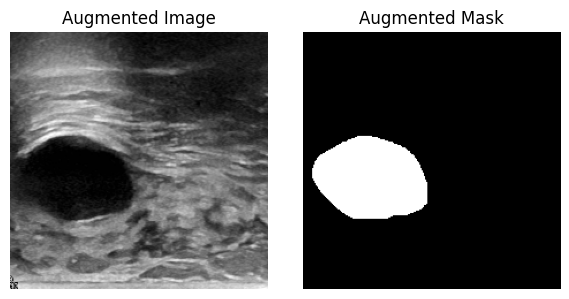

In [4]:
def visualize_augmentations(dataset, num_samples=5):
    """
    Visualizes augmented samples from a given dataset.

    Args:
        dataset: An instance of BreastDataset with augmentations.
        num_samples: Number of samples to visualize.
    """

    dataset.eval_mode = True  # just in case your dataset tracks state
    for i in range(num_samples):
        image, mask = dataset[i]

        # Convert tensors to numpy
        img_np = image.squeeze().cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()

        # Denormalize image (reverse of A.Normalize)
        img_np = (img_np * 0.5 + 0.5)  # From [-1, 1] to [0, 1]

        # Plotting
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(img_np, cmap='gray')
        plt.title("Augmented Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title("Augmented Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
(train_imgs, train_masks), _, _ = load_split_data()
train_dataset = BreastDataset(train_imgs, train_masks, train_transform)
image, mask = train_dataset[0]

# Convert tensors to numpy
img_np = image.squeeze().cpu().numpy()
mask_np = mask.squeeze().cpu().numpy()
print(img_np.shape)
print(mask_np.shape)
print(np.unique(mask_np))
visualize_augmentations(train_dataset, num_samples=5)

✅ Loaded model from trained_models/reconstruction/20250528_144058/best_model.pth

🎯 Average Dice Score on Test Set: 0.7213



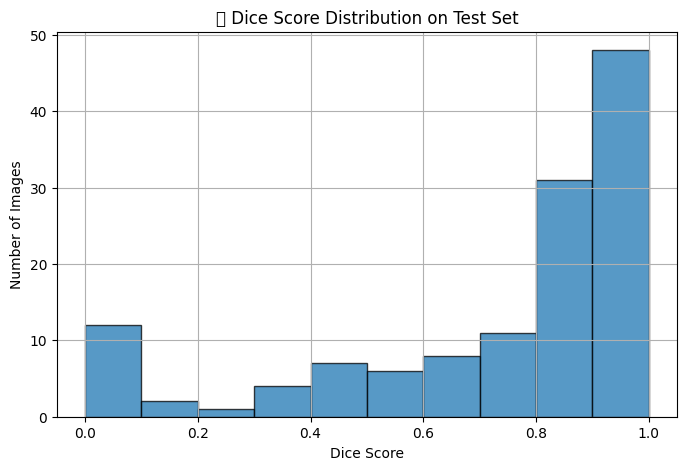

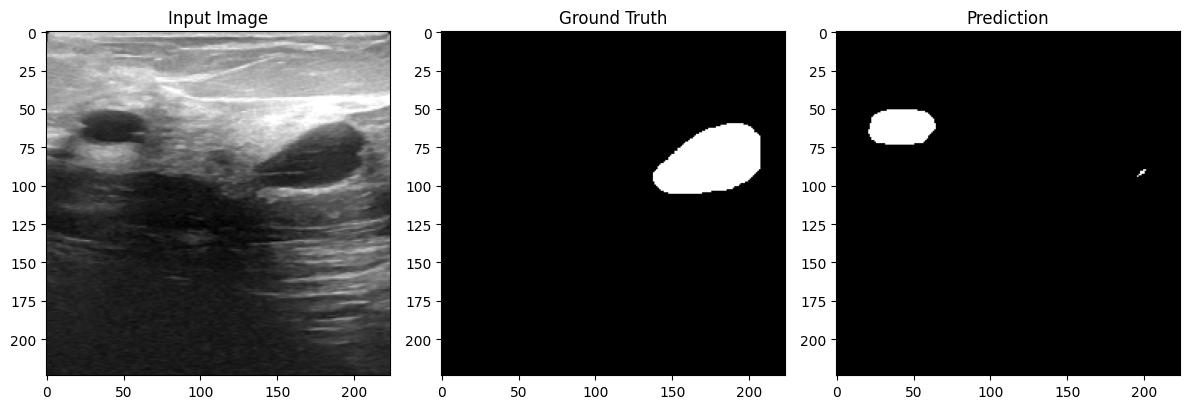

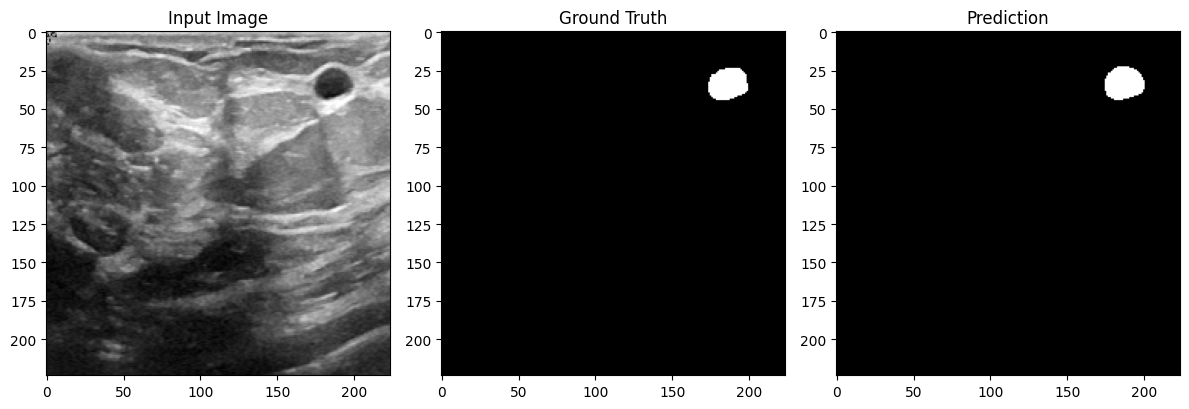

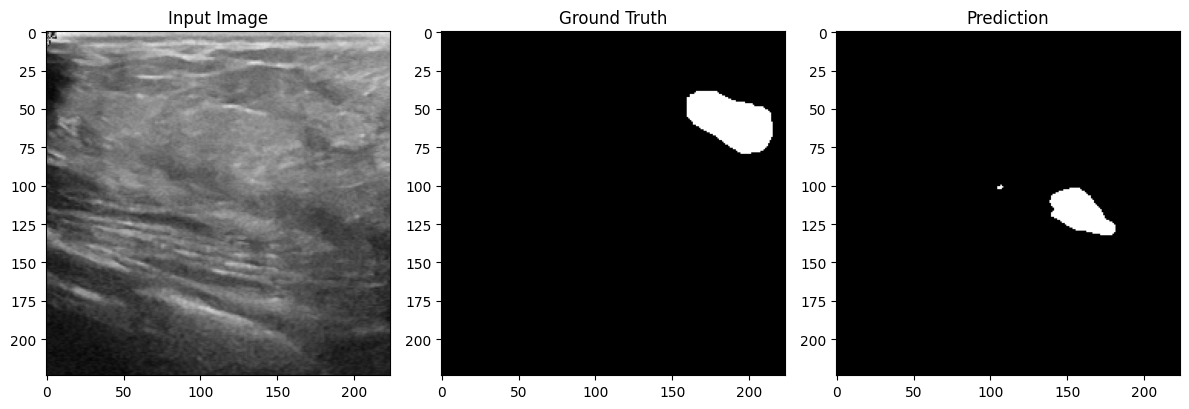

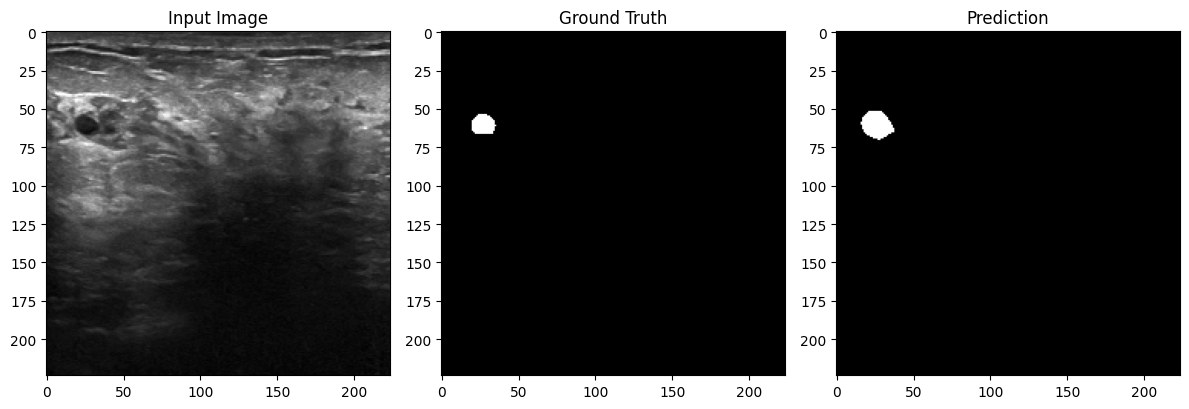

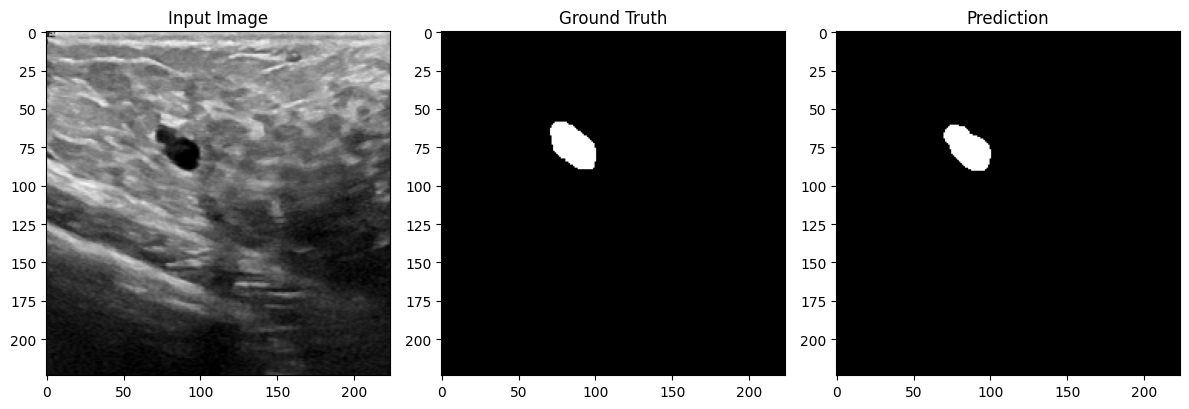

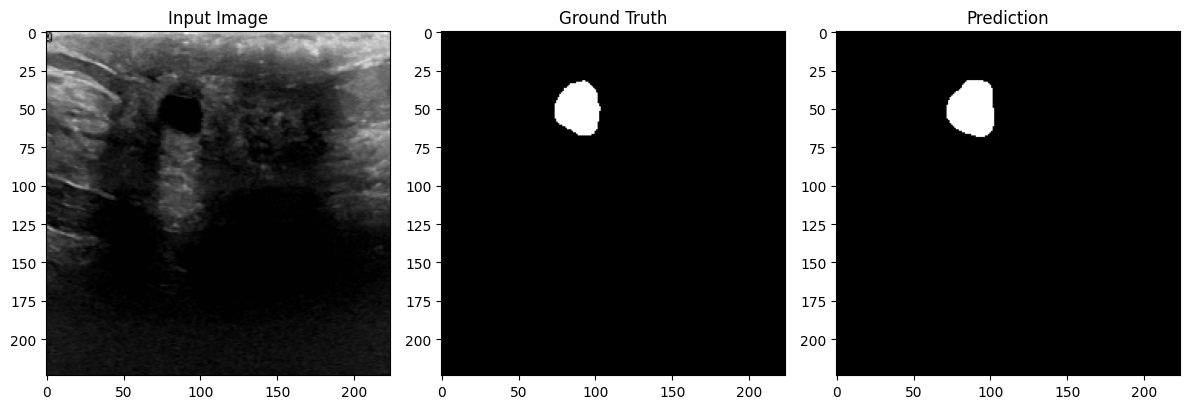

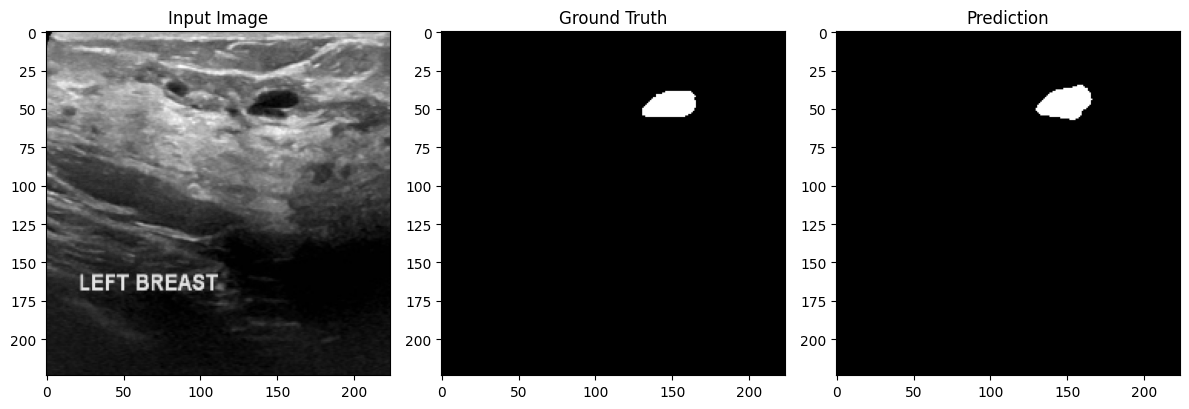

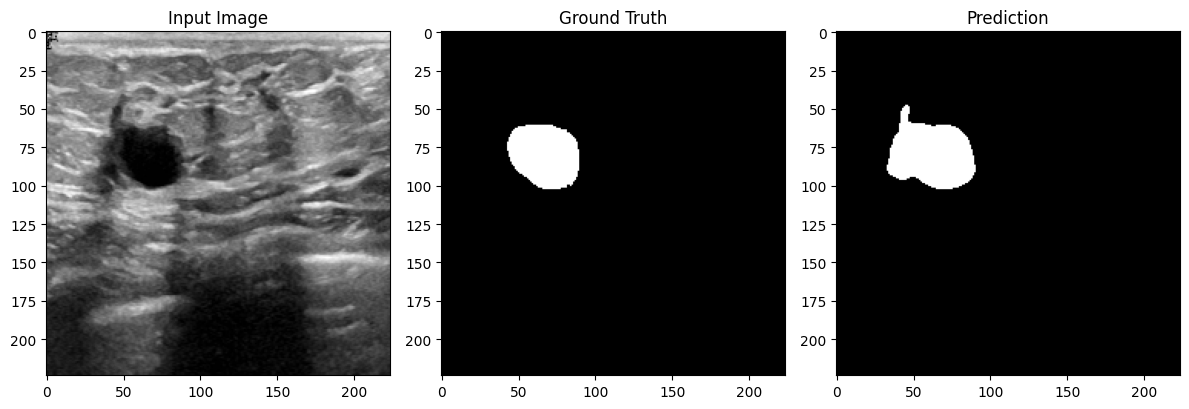

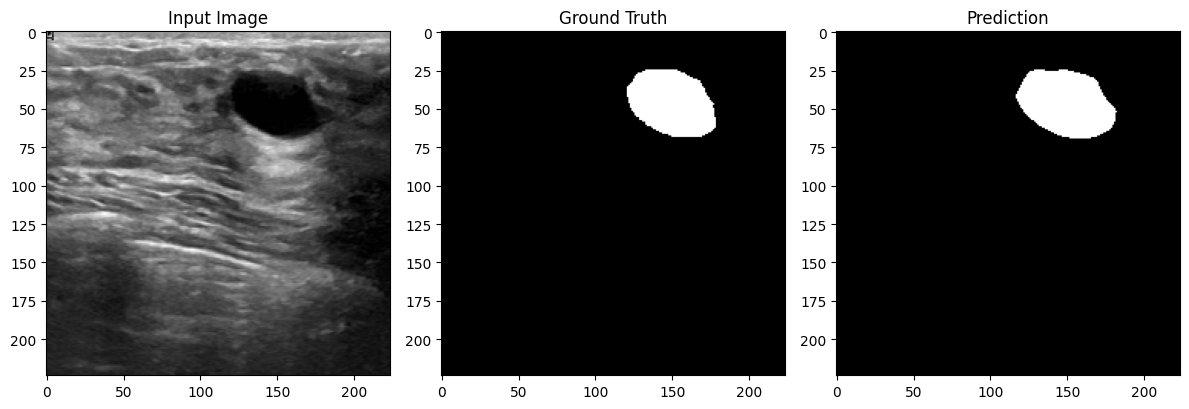

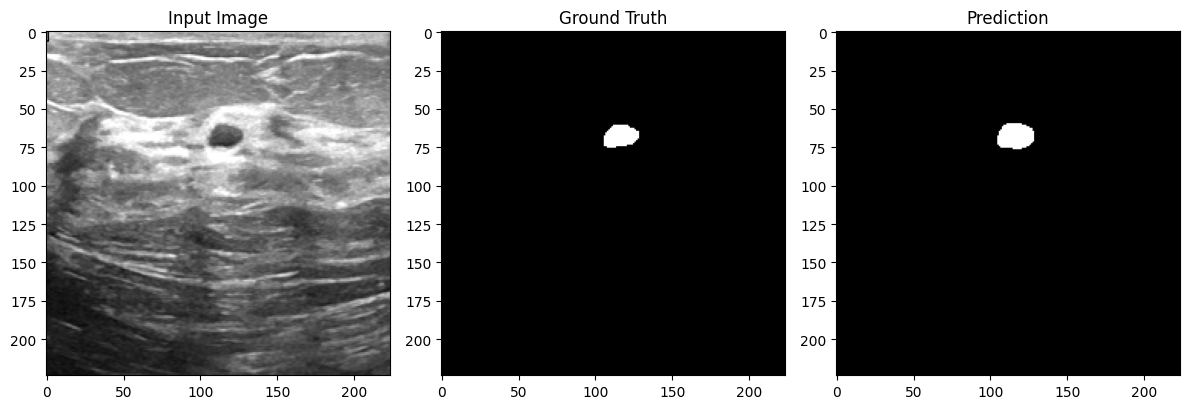

In [8]:
# checkpoint = "trained_models/augumentation/20250513_074339/best_model.pth"
# checkpoint = "trained_models/base/best_model.pth"
# checkpoint = "trained_models/augumentation2/20250517_090006/best_model.pth"
# checkpoint = "trained_models/base2/20250517_101215/best_model.pth"
# checkpoint = "trained_models/base_300_epochs/20250517_103013/best_model.pth"
# checkpoint = "trained_models/augumentation_300_epochs/20250517_103146/best_model.pth"
checkpoint = "trained_models/reconstruction/20250528_144058/best_model.pth"
# Existing Dice score function remains unchanged
def dice_score_batch(preds, targets, threshold=0.5):
    """Returns Dice score per sample in batch."""
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    targets = targets.float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = (preds + targets).sum(dim=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-8)
    return dice  # Returns a tensor of shape (batch_size,)

# Visualization
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()
    count = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            preds,_ = model(images)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                if count >= num_images:
                    return
                plt.figure(figsize=(12, 4))

                img = images[i].squeeze().cpu().numpy()
                true = masks[i].squeeze().cpu().numpy()
                pred = preds[i].squeeze().cpu().numpy()

                plt.subplot(1, 3, 1)
                plt.imshow(img, cmap="gray")
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(true, cmap="gray")
                plt.title("Ground Truth")

                plt.subplot(1, 3, 3)
                plt.imshow(pred, cmap="gray")
                plt.title("Prediction")

                plt.tight_layout()
                plt.show()
                count += 1
                
# Main evaluation function
def evaluate():
    # Load data
    _, _, (test_imgs, test_masks) = load_split_data()
    
    test_dataset = BreastDataset(test_imgs, test_masks, val_transform)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_network(
        vit_name="R50-ViT-B_16",
        img_size=224,
        num_classes=1,
        n_skip=3,
        vit_patches_size=16,
    ).to(device)

    # Load trained weights
    if os.path.exists(checkpoint):
        model.load_state_dict(torch.load(checkpoint, map_location=device))
        print(f"✅ Loaded model from {checkpoint}")
    else:
        print(f"❌ Model checkpoint {checkpoint} not found.")
        return

    # Evaluate Dice Scores per image
    model.eval()
    all_dice_scores = []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs,_ = model(images)
            batch_dice = dice_score_batch(outputs, masks)
            all_dice_scores.extend(batch_dice.cpu().numpy())

    # Compute average Dice Score
    avg_dice = sum(all_dice_scores) / len(all_dice_scores)
    print(f"\n🎯 Average Dice Score on Test Set: {avg_dice:.4f}\n")

    # Plot Dice Score Histogram
    plt.figure(figsize=(8, 5))
    plt.hist(all_dice_scores, bins=10, range=(0, 1), edgecolor="black", alpha=0.75)
    plt.title("📊 Dice Score Distribution on Test Set")
    plt.xlabel("Dice Score")
    plt.ylabel("Number of Images")
    plt.grid(True)
    plt.show()

    # Visualize predictions
    visualize_predictions(model, test_loader, device, num_images=10)

evaluate()
